In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/2022/classes/stat195/stat195project')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/2022/classes/stat195/stat195project


In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
import torch

sys.path.append("aav/util")

# The canonical single-letter code residue alphabet.
RESIDUES = tuple('ACDEFGHIKLMNPQRSTVWY')

# The AAV serotype 2 wild type subsequence corresponding to positions 561 to 588
R1_TILE21_WT_SEQ = 'DEEEIRTTNPVATEQYGSVSTNLQRGNR'

In [3]:
!pip install lassonet

In [4]:
from lassonet import LassoNetClassifier

In [5]:
df = pd.read_csv("stat_195_project_data.csv")

In [6]:
df_r2 = df[df["partition"] == "random_doubles"]

In [9]:
from residue_encoding import ResidueIdentityEncoder
from mutation_encoding import MutationSequenceEncoder

res_encoder = ResidueIdentityEncoder(alphabet=RESIDUES)
mut_encoder = MutationSequenceEncoder(res_encoder, R1_TILE21_WT_SEQ)

In [21]:
clf_logistic = LassoNetClassifier(hidden_dims=(1,), M=300)

In [20]:
num_points = 15000
X = df_r2["sequence"]
X_train = np.array([mut_encoder.encode(X.iloc[i]).flatten() for i in range(num_points)])
y_train = df_r2["is_viable"][:num_points].to_numpy().astype(int)

X_test = np.array([mut_encoder.encode(X.iloc[i]).flatten() for i in range(num_points, int(1.1*num_points))])
y_test = df_r2["is_viable"][num_points:int(1.1*num_points)].to_numpy().astype(int)

print(len(X_train), len(y_train), len(X_test), len(y_test))

15000 15000 1500 1500


In [22]:
path = clf_logistic.path(X_train, y_train)

In [23]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_selected = []
accuracy = []
lambda_ = []

for save in path:
    clf_logistic.load(save.state_dict)
    y_pred = clf_logistic.predict(X_test)
    # print(y_pred)
    n_selected.append(save.selected.sum())
    accuracy.append(accuracy_score(y_test, y_pred))
    lambda_.append(save.lambda_)

In [28]:
print(max(accuracy))

0.9893333333333333


Text(0, 0.5, 'number of selected features')

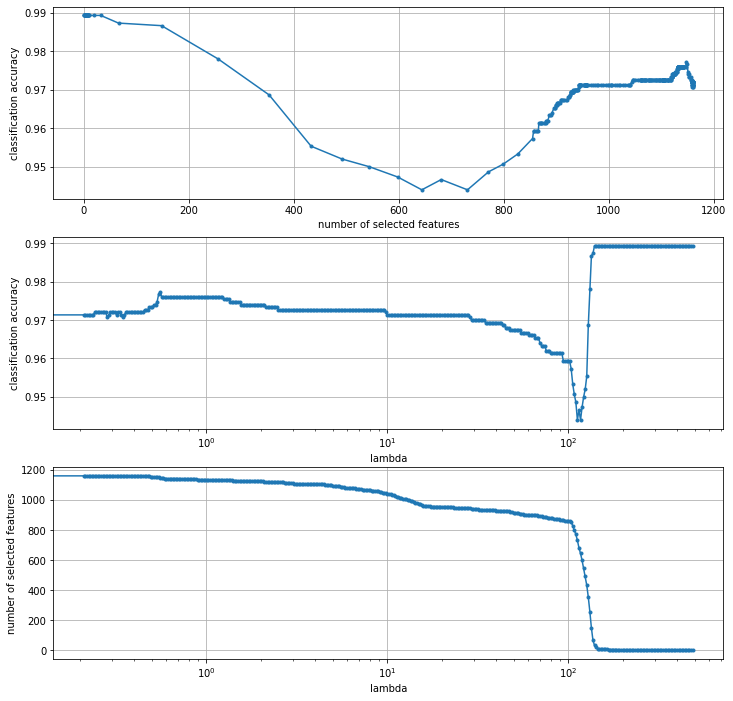

In [24]:
fig = plt.figure(figsize=(12, 12))

plt.subplot(311)
plt.grid(True)
plt.plot(n_selected, accuracy, ".-")
plt.xlabel("number of selected features")
plt.ylabel("classification accuracy")

plt.subplot(312)
plt.grid(True)
plt.plot(lambda_, accuracy, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("classification accuracy")

plt.subplot(313)
plt.grid(True)
plt.plot(lambda_, n_selected, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("number of selected features")

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
clf_logistic_standard = LogisticRegression()
clf_logistic_standard.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [27]:
y_pred = clf_logistic_standard.predict(X_test)
accuracy_score(y_test, y_pred)

0.9206666666666666